Curve cleaning, curve fitting and the exploration about the corrrelations between deviations and weather factors for each cow

In [1]:
#Imports
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 150
import datetime as dt
import numpy as np
from scipy import signal
import sklearn.linear_model as skl_lm
import time
import math
sns.set()

In [2]:
# Importing the milking data and cleaning it a bit
milk = pd.read_csv("AllMilkings.csv", usecols=["StartDate", "FarmName_Pseudo", "SE_Number", "SE_Number", "LactationNumber", "DaysInMilk", "TotalYield"])
milk = milk[milk["TotalYield"].notnull()]
milk = milk[milk["SE_Number"] != "Unknown"]
milk = milk.drop_duplicates()
milk["StartDate"] = pd.to_datetime(milk["StartDate"])
milk = milk.sort_values(["StartDate"])
milk = milk.groupby(["SE_Number","StartDate"]).agg({"TotalYield": "sum", "DaysInMilk": "first", "LactationNumber": "first", "FarmName_Pseudo": "first"})
milk = milk.reset_index()

In [3]:
# Filtering out all cows that could potentially be used
allCowNames = milk["SE_Number"].unique()
longCowNames = []
for name in allCowNames:
    cow = milk[milk["SE_Number"] == name]
    l = len(cow)
    LP = cow["LactationNumber"].count()/l
    DP = cow["DaysInMilk"].count()/l
    if LP == 1 and DP > 0.8 and l > 150:
        longCowNames.append(name)

In [4]:
# Remove outliers
def zDrop(curve1):
    yield_mean = curve1["TotalYield"].mean()
    curve = curve1.copy()
    # If the time inverval between two continuous records in one lactation is more than 30 days, the latter one is regarded as wrong record and dropped.
    curve = curve.set_index(curve["StartDate"])
    differ = curve["StartDate"] - curve["StartDate"].shift(1, fill_value = curve["StartDate"].iloc[0])
    curve["differ_days"] = differ.dt.days
    curve = curve.drop(index = curve[curve["differ_days"] > 30].index)
    curve = curve.drop(["differ_days"], axis = 1)
    
    # Remove the records whose yields are too large
    curve.loc[curve["TotalYield"] > yield_mean * 2, "TotalYield"] = np.nan
    window = 14
    # Remove outliers using z-score
    roll = curve["TotalYield"].rolling(window)
    curve.loc[:, 'z-score'] = (curve.loc[:, "TotalYield"] - roll.mean()) / roll.std()
    curve.loc[:, "TotalYield"] = curve.loc[:, "TotalYield"].mask(abs(curve.loc[:, "z-score"])>2)
    curve = curve.drop("z-score", axis = 1)
    return curve

In [5]:
# Estimating the start of a lactaion curve using formulas made by Anna Edvardsson Rasmussen
def calcBeginning(firstLact):
    #Seting intercept as half of the mean instead of zero since that is close to the average of the complete curves in the data
    intercept = 0.5*firstLact["TotalYield"].mean()
    MYminDIMmedel = firstLact["TotalYield"].iloc[0:3].mean()
    minDIM = firstLact['DaysInMilk'].iloc[0]

    SE_Number = firstLact['SE_Number'].iloc[0]
    StartDate = firstLact['StartDate'].iloc[0] - dt.timedelta(days=1)
    #TotalYield = np.nan
    DaysInMilk = firstLact['DaysInMilk'].iloc[0] - 1
    LactationNumber = firstLact['LactationNumber'].iloc[0]
    FarmName_Pseudo = firstLact['FarmName_Pseudo'].iloc[0]

    #Calculating the beginning of the curve and concatenating it with the incomplete curve
    while DaysInMilk > 0:
        x = (MYminDIMmedel-intercept)/(np.log(minDIM))
        MY = x * np.log(DaysInMilk) + intercept

        d = {"SE_Number": SE_Number, "StartDate": StartDate, "TotalYield": MY, "DaysInMilk": DaysInMilk, "LactationNumber": LactationNumber, "FarmName_Pseudo": FarmName_Pseudo}
        q = pd.DataFrame(d, index = [0])

        firstLact = pd.concat([q, firstLact], ignore_index=True)

        DaysInMilk = DaysInMilk - 1
        StartDate = StartDate - dt.timedelta(days=1)

    return firstLact

In [6]:
# Filling holes using a combinateion of rolling mean and linear interpolation
def interpolateMissing(curve):
    SE_Number = curve['SE_Number'].iloc[0]
    LactationNumber = curve['LactationNumber'].iloc[0]
    FarmName_Pseudo = curve['FarmName_Pseudo'].iloc[0]

    curve = curve.set_index("StartDate")

    firstDate = curve.index[0]
    lastDate = curve.index[-1]

    idx = pd.date_range(firstDate, lastDate)
    curve = curve.reindex(idx, fill_value= np.nan)

    curve['rollmean20'] = curve['TotalYield'].rolling(20,center=True,min_periods=1).mean()

    for index, row in curve.iterrows():
        if pd.isna(curve['SE_Number'].loc[index]):
            curve.loc[index, 'SE_Number'] = SE_Number
            curve.loc[index, 'FarmName_Pseudo'] = FarmName_Pseudo
            curve.loc[index, 'LactationNumber'] = LactationNumber
            nDays = (index - firstDate).days
            curve.loc[index, 'DaysInMilk'] = nDays + 1
            curve.loc[index, 'TotalYield'] = curve.loc[index, 'rollmean20']

    curve = curve.interpolate(method = "linear")

    return curve

In [7]:
# Apply zDrop, calcBeginning, interpolateMissing to every lactation of each cow
curves = []
for name in longCowNames:
    cow = milk[milk["SE_Number"] == name]
    lactations = cow["LactationNumber"].unique()
    lactations = [int(x) for x in lactations if str(x) != 'nan']
    
    for lactation in lactations:
        eachLact = cow[cow["LactationNumber"] == lactation]
        eachLact = zDrop(eachLact)
        firstDIM = eachLact['DaysInMilk'].iloc[0]
        lastDIM = eachLact['DaysInMilk'].iloc[-1]
        if firstDIM <= 60:
            eachLact = calcBeginning(eachLact)
            # Append to the set of good curves if not too long
            if len(eachLact) < 400:
                curves.append(interpolateMissing(eachLact))

In [8]:
# Adding weather data to all cows
milk = pd.concat(curves)
milk = milk.reset_index()
milk = milk.rename(columns={"index": "StartDate"})

weatherCols = ["Timestamp", "T_C_mean", "THI_mean", "THI_adj_mean", "r_sfc_mean"]
uniqueFarms = milk["FarmName_Pseudo"].unique()
df = pd.DataFrame()
for farm in uniqueFarms:
    tf = pd.read_csv(f"E:/Computational Science/project/TempGroup/weather data/weatherandthi/{farm}_weather_daily.csv", usecols=weatherCols)
    tf["FarmName_Pseudo"] = farm
    df = pd.concat([df, tf])

df["Timestamp"] = pd.to_datetime(df["Timestamp"])
milk = pd.merge(milk, df,  how='left', left_on=['StartDate','FarmName_Pseudo'], right_on = ['Timestamp','FarmName_Pseudo'])


In [9]:
# Replace the farms' name
rDict = {"a624fb9a": "Farm 1",
        "ab18b151": "Farm 2",
        "540275a1": "Farm 3",
        "5b581702": "Farm 4",
        "5c06d92d": "Farm 5",
        "a756bc39": "Farm 6",
        "ad0a39f5": "Farm 7",
        "752efd72": "Farm 8",
        "f454e660": "Farm 9"}
milk = milk.replace({"FarmName_Pseudo": rDict})

In [10]:
# Replace the weather factors' names
milk = milk.rename(columns = {"T_C_mean":"Temperature",
                              "THI_mean": "THI",
                              "THI_adj_mean": "THI_adj",
                              "r_sfc_mean": "Relative humidity"})

In [11]:
# Wilmink lactation curve
def wilmink_lactation(t, y):
    t = np.array(list(map(float,t)))
    x1 = t
    x2 = np.array(list(map(lambda x: math.exp(-0.05*x),t)))
    x = np.array([x1.T, x2.T]).T
    model = skl_lm.LinearRegression(fit_intercept = True)
    model.fit(x,y)
    prediction = model.predict(x)
    return prediction

In [12]:
# apply the wilmink model to every cow
farms = milk["FarmName_Pseudo"].unique()
for farm in farms:
    cows = milk[milk["FarmName_Pseudo"] == farm]["SE_Number"].unique()
    for cow in cows:
        data_cow = milk[milk["SE_Number"] == cow]
        lactations = data_cow["LactationNumber"].unique()
        for lactation in lactations:
            cow_lac = data_cow[data_cow["LactationNumber"] == lactation]
            cow_lac1 = cow_lac.copy()
            yield_wilmink = wilmink_lactation(cow_lac1["DaysInMilk"].tolist(), cow_lac1["TotalYield"].tolist())
            # Compute the Deviation
            cow_lac1["Deviation"] = cow_lac1["TotalYield"] - yield_wilmink
            cow_lac1["Yield_Wilmink"] = yield_wilmink
            milk.loc[cow_lac1.index, "Deviation"] = cow_lac1["Deviation"]
            milk.loc[cow_lac1.index, "Yield_Wilmink"] = cow_lac1["Yield_Wilmink"]

In [13]:
milk

,StartDate,SE_Number,TotalYield,DaysInMilk,LactationNumber,FarmName_Pseudo,rollmean20,Timestamp,Relative humidity,Temperature,THI,THI_adj,Deviation,Yield_Wilmink
0,2019-11-27,SE-064c0cec-1179,19.189937,1.0,5.0,Farm 1,31.456242,2019-11-27,0.985456,0.554000,32.796070,34.059469,-8.322754,27.512691
1,2019-11-28,SE-064c0cec-1179,11.740000,2.0,5.0,Farm 1,32.243326,2019-11-28,0.964386,-0.698917,30.199881,29.196953,-16.866707,28.606707
2,2019-11-29,SE-064c0cec-1179,25.920000,3.0,5.0,Farm 1,31.962994,2019-11-29,0.889705,-3.386292,23.958077,25.567343,-3.723628,29.643628
3,2019-11-30,SE-064c0cec-1179,37.410000,4.0,5.0,Farm 1,32.899085,2019-11-30,0.841099,-4.050417,21.826228,25.287756,6.783762,30.626238
4,2019-12-01,SE-064c0cec-1179,34.005828,5.0,5.0,Farm 1,34.005828,2019-12-01,0.844470,-5.037458,19.950748,26.549373,2.448643,31.557185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126826,2022-08-19,SE-f454e660-686,18.140000,179.0,1.0,Farm 9,19.287143,2022-08-19,0.773764,23.855208,77.637745,71.985035,-0.029528,18.169528
126827,2022-08-20,SE-f454e660-686,19.880000,180.0,1.0,Farm 9,19.506923,2022-08-20,0.891669,21.952500,72.418048,68.082749,1.754399,18.125601
126828,2022-08-21,SE-f454e660-686,18.350000,181.0,1.0,Farm 9,19.365000,2022-08-21,0.795920,18.370458,65.997363,63.825121,0.268328,18.081672
126829,2022-08-22,SE-f454e660-686,26.390000,182.0,1.0,Farm 9,19.197273,2022-08-22,0.705045,18.298375,66.268228,63.972419,8.352258,18.037742


In [14]:
colors = ["#CE0037", "#00b0b9", "#FFB81C", "#509E2F", "#672146", "#007681", "#996017", "#79863C"]
customPalette = sns.set_palette(sns.color_palette(colors))

pearson correlations
Farm 1
with Temperature: -0.011663737119672868
with Temperature during summer: -0.10193562170119456
with THI: -0.014185996611250733
with THI during summer: -0.10114472800806999
with THI_adj: -0.010744054647892269
with THI_adj during summer: -0.09269586943168419
with Relative humidity: -0.016575640010758647
with Relative humidity during summer: 0.021313792786387703
Farm 2
the cows whose correlations are 1 during summer time:SE-ab18b151-1318
with Temperature: -0.06858230595374692
with Temperature during summer: 0.010309205882406625
with THI: -0.07008503660374925
with THI during summer: 0.014515032623847185
with THI_adj: -0.06229061422911231
with THI_adj during summer: -0.0967602461789666
with Relative humidity: -0.01247884500351851
with Relative humidity during summer: 0.1046739489733853
Farm 3
with Temperature: 0.04680078680059197
with Temperature during summer: 0.011184399687529286
with THI: 0.05557253891410391
with THI during summer: 0.009535064946108264
with THI_

d:\python\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\python\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


with Temperature: 0.03417948316213657
with Temperature during summer: -0.20065765169657063
with THI: 0.032634152851818
with THI during summer: -0.1911928296861383
with THI_adj: 0.03355926610483453
with THI_adj during summer: -0.19529823723911807
with Relative humidity: -0.005225240584219746
with Relative humidity during summer: 0.053892555485289595
Farm 9
with Temperature: -0.015408930276904473
with Temperature during summer: -0.06458219436238137
with THI: -0.015596716198672282
with THI during summer: -0.06086421749982615
with THI_adj: -0.009090938601139752
with THI_adj during summer: -0.05701360985828838
with Relative humidity: -0.020835286827245
with Relative humidity during summer: -0.016460916628624672


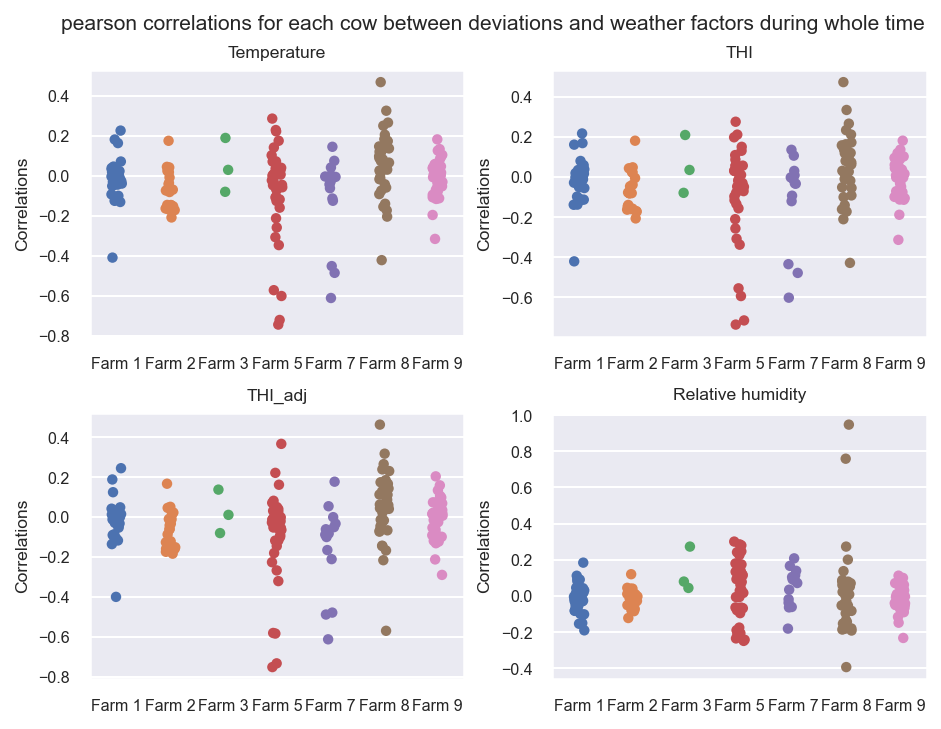

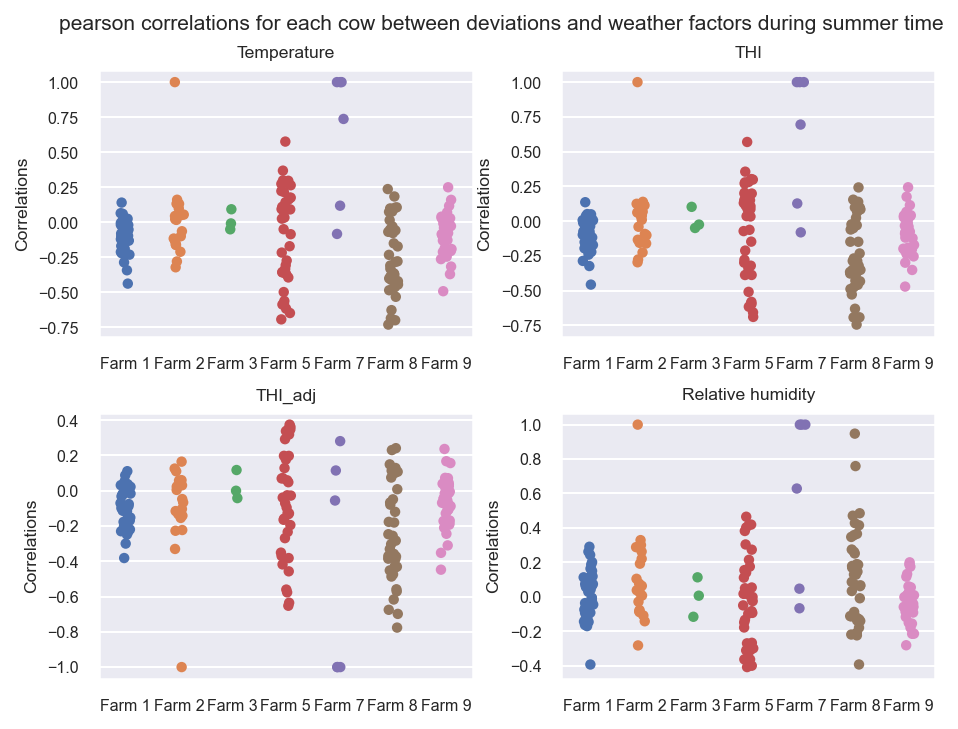

kendall correlations
Farm 1
with Temperature: -0.012303426259353484
with Temperature during summer: -0.06795041071569842
with THI: -0.013485306528849857
with THI during summer: -0.06819657715841228
with THI_adj: -0.01195355158399162
with THI_adj during summer: -0.06323975683983254
with Relative humidity: -0.011006387788623659
with Relative humidity during summer: 0.02105204944605034
Farm 2
the cows whose correlations are 1 during summer time:SE-ab18b151-1318
the cows whose correlations are 1 during summer time:SE-ab18b151-1318
the cows whose correlations are 1 during summer time:SE-ab18b151-1318
with Temperature: -0.03886776154900123
with Temperature during summer: 0.02805597871449992
with THI: -0.0396189188895593
with THI during summer: 0.02690486107511731
with THI_adj: -0.033167804783749984
with THI_adj during summer: -0.07266045455866296
with Relative humidity: -0.0029690133162759507
with Relative humidity during summer: 0.10268350267352985
Farm 3
with Temperature: 0.021269837228120

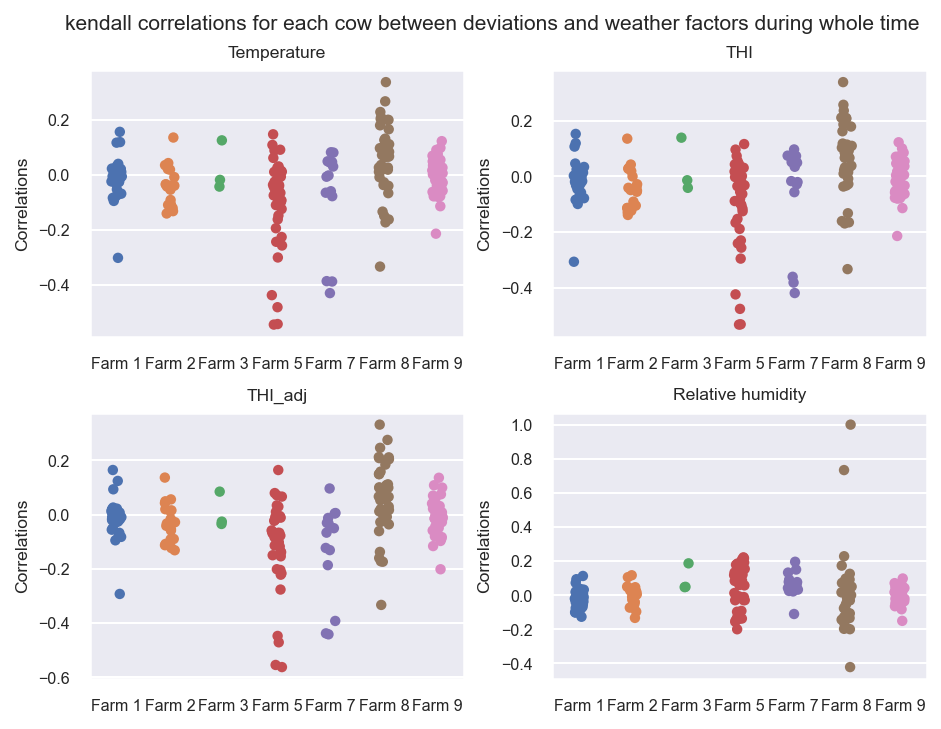

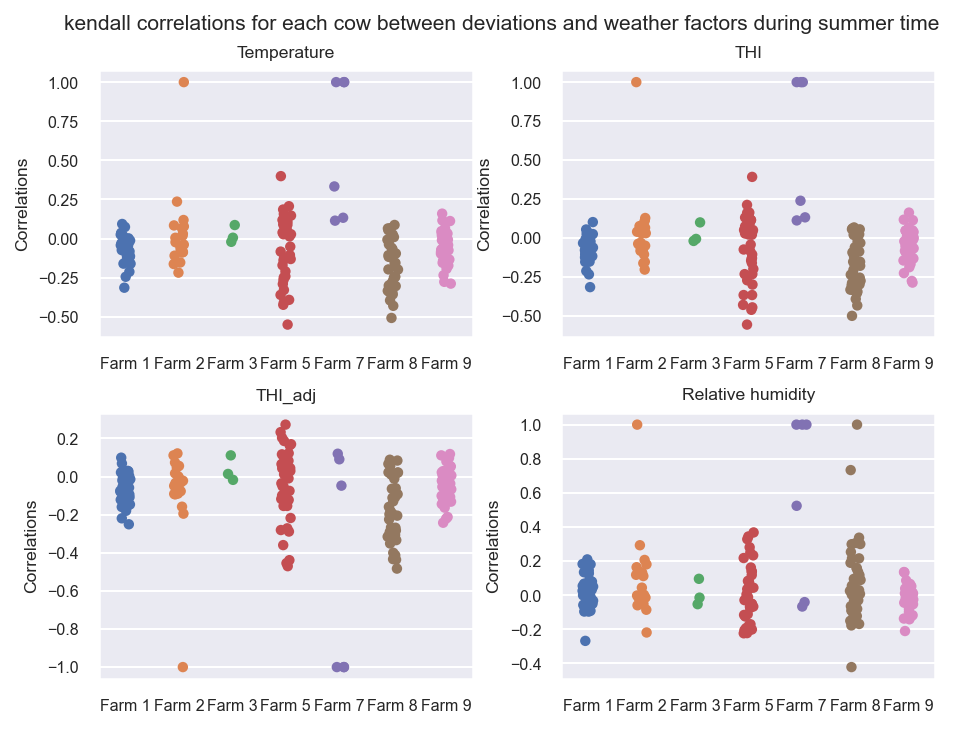

spearman correlations
Farm 1
with Temperature: -0.019359679053510288
with Temperature during summer: -0.10063118909727846
with THI: -0.02087347801938884
with THI during summer: -0.10078906707715707
with THI_adj: -0.019240366671933008
with THI_adj during summer: -0.09454143572771535
with Relative humidity: -0.016347318569579675
with Relative humidity during summer: 0.03288541672472317
Farm 2
with Temperature: -0.05800015837555278
with Temperature during summer: 0.019401880419222816
with THI: -0.05926605356455632
with THI during summer: 0.019683359567684376
with THI_adj: -0.0502925325822132
with THI_adj during summer: -0.08009281026940826
with Relative humidity: -0.004007885034434352
with Relative humidity during summer: 0.1239362134527294
Farm 3
with Temperature: 0.031700224748450224
with Temperature during summer: 0.035557544724441836
with THI: 0.04196136068431358
with THI during summer: 0.040470388838444574
with THI_adj: 0.008083647490886359
with THI_adj during summer: 0.0528734160815

d:\python\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


with Temperature: 0.06247783994390318
with Temperature during summer: -0.21073734149676782
with THI: 0.06468064155431733
with THI during summer: -0.2020863450868176
with THI_adj: 0.06264830278096865
with THI_adj during summer: -0.20318783852580263
with Relative humidity: -0.007997632590564855
with Relative humidity during summer: 0.043516269691269906
Farm 9
with Temperature: -0.015516276107664206
with Temperature during summer: -0.0695626392146749
with THI: -0.016383190153655858
with THI during summer: -0.06778537663371058
with THI_adj: -0.010241805960426922
with THI_adj during summer: -0.061831845389928176
with Relative humidity: -0.01767751454088053
with Relative humidity during summer: -0.01688726311388536


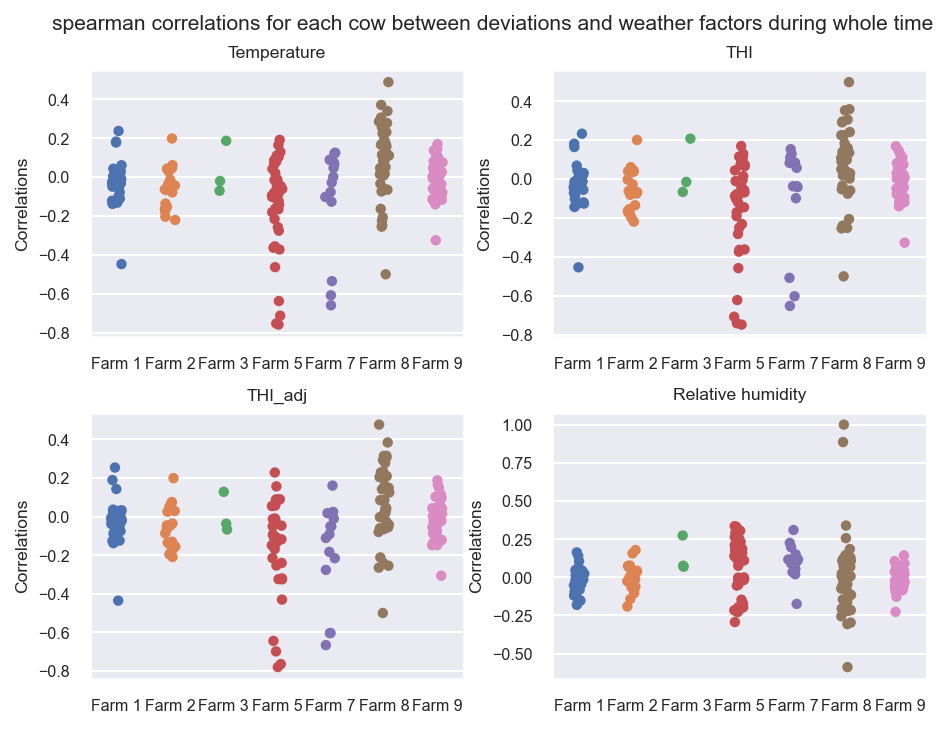

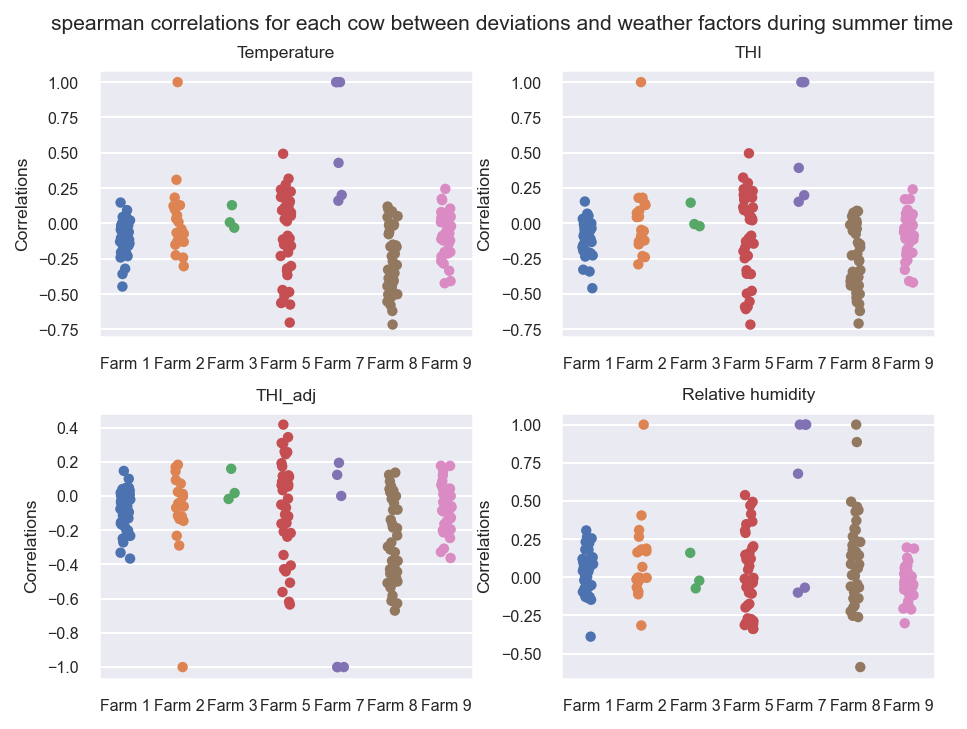

In [15]:
sns.set(font_scale = 0.7)
farms = ['Farm 1', 'Farm 2', 'Farm 3', 'Farm 5', 'Farm 7', 'Farm 8', 'Farm 9']
weathers = ["Temperature", "THI", "THI_adj", "Relative humidity"]
methods = ["pearson", "kendall", "spearman"]
for method in methods:
    df_all_T = pd.DataFrame()
    df_all_T_summer = pd.DataFrame()
    df_all_THI = pd.DataFrame()
    df_all_THI_summer = pd.DataFrame()
    df_all_THIA = pd.DataFrame()
    df_all_THIA_summer = pd.DataFrame()
    df_all_r = pd.DataFrame()
    df_all_r_summer = pd.DataFrame()
    print(f"{method} correlations")
    for farm in farms:
        print(f"{farm}")
        df_wea = pd.DataFrame()
        cows = milk[milk["FarmName_Pseudo"] == farm]["SE_Number"].unique()
        df_wea["SE_Number"] = cows
        df_wea.set_index("SE_Number", inplace = True)
        for cow in cows:
            data_cow = milk[milk["SE_Number"] == cow]
            summer= data_cow[((data_cow["Timestamp"] >= "2020-6-1") & (data_cow["Timestamp"] <= "2020-8-31")) | ((data_cow["Timestamp"] >= "2021-6-1") & (data_cow["Timestamp"] <= "2021-8-31")) | ((data_cow["Timestamp"] >= "2022-6-1") & (data_cow["Timestamp"] <= "2022-8-31"))]
            for i in range(len(weathers)):
                # Compute the average correlation between deviations and weather factors for every cow
                corr = data_cow["Deviation"].corr(data_cow[weathers[i]],method = method)
                corr_summer = summer["Deviation"].corr(summer[weathers[i]],method = method)
                df_wea.loc[cow, f"{method}_{weathers[i]}"] = corr
                df_wea.loc[cow, f"{method}_{weathers[i]}_summer"] = corr_summer
                # Detect the cows whose correlations are 1
                if corr == 1:
                    print(f"the cows whose correlations are 1 during whole time:{cow}")
                if corr_summer == 1:
                    print(f"the cows whose correlations are 1 during summer time:{cow}")
               

        # Compute the average correlation between deviations and weather factors for every farm
        for weather in weathers:
            corr_mean = df_wea[f"{method}_{weather}"].mean()
            corr_mean_summer = df_wea[f"{method}_{weather}_summer"].mean()
            print(f"with {weather}: {corr_mean}")
            print(f"with {weather} during summer: {corr_mean_summer}")

        df_wea = df_wea.reset_index(drop=True)
        df_all_T[f"{farm}"] = df_wea[f"{method}_Temperature"]
        df_all_T_summer[f"{farm}"] = df_wea[f"{method}_Temperature_summer"]
        df_all_THI[f"{farm}"] = df_wea[f"{method}_THI"]
        df_all_THI_summer[f"{farm}"] = df_wea[f"{method}_THI_summer"]
        df_all_THIA[f"{farm}"] = df_wea[f"{method}_THI_adj"]
        df_all_THIA_summer[f"{farm}"] = df_wea[f"{method}_THI_adj_summer"]
        df_all_r[f"{farm}"] = df_wea[f"{method}_Relative humidity"]
        df_all_r_summer[f"{farm}"] = df_wea[f"{method}_Relative humidity_summer"]

    # Plot the distribution of the correlations for every cow in each farm during the whole time
    fig1, axs1 = plt.subplots(2,2)
    fig1.tight_layout(pad = 2)
    axs1 = axs1.ravel()
    sns.stripplot(data = df_all_T, ax = axs1[0])
    sns.stripplot(data = df_all_THI, ax = axs1[1])
    sns.stripplot(data = df_all_THIA, ax = axs1[2])
    sns.stripplot(data = df_all_r, ax = axs1[3])

    for i in range(4):
        axs1[i].set_ylabel("Correlations")
        axs1[i].set_title(f"{weathers[i]}")

    plt.suptitle(f"{method} correlations for each cow between deviations and weather factors during whole time", x = 0.5, y = 1.02)
    plt.savefig(f"correlations_cow_{method}", bbox_inches = 'tight')
    plt.show()
    
    # Plot the distribution of the correlations for every cow in each farm during summer time
    fig2, axs2 = plt.subplots(2,2)
    fig2.tight_layout(pad = 2)
    axs2 = axs2.ravel()
    sns.stripplot(data = df_all_T_summer, ax = axs2[0])
    sns.stripplot(data = df_all_THI_summer, ax = axs2[1])
    sns.stripplot(data = df_all_THIA_summer, ax = axs2[2])
    sns.stripplot(data = df_all_r_summer, ax = axs2[3])

    for i in range(4):
        axs2[i].set_ylabel("Correlations")
        axs2[i].set_title(f"{weathers[i]}")

    plt.suptitle(f"{method} correlations for each cow between deviations and weather factors during summer time", x = 0.5, y = 1.02)
    plt.savefig(f"correlations_cow_summer_{method}", bbox_inches = 'tight')
    plt.show()
    
    # Every dot represents the correlation for the corresponding cow.

In [16]:
# Detect the cows whose correlations are 1 in Farm 2 during summer time
cow1318 = milk[milk["SE_Number"] == "SE-ab18b151-1318"]
cow1318_summer = cow1318[((cow1318["Timestamp"] >= "2020-6-1") & (cow1318["Timestamp"] <= "2020-8-31")) | ((cow1318["Timestamp"] >= "2021-6-1") & (cow1318["Timestamp"] <= "2021-8-31")) | ((cow1318["Timestamp"] >= "2022-6-1") & (cow1318["Timestamp"] <= "2022-8-31"))]
print(f"the number of records for cow SE-ab18b151-1318 during summertime: {len(cow1318_summer)}")

the number of records for cow SE-ab18b151-1318 during summertime: 2


In [17]:
# Detect the cows whose correlations are 1 in Farm 7 during summer time
cow2282 = milk[milk["SE_Number"] == "SE-ad0a39f5-2282"]
cow2282_summer = cow2282[((cow2282["Timestamp"] >= "2020-6-1") & (cow2282["Timestamp"] <= "2020-8-31")) | ((cow2282["Timestamp"] >= "2021-6-1") & (cow2282["Timestamp"] <= "2021-8-31")) | ((cow2282["Timestamp"] >= "2022-6-1") & (cow2282["Timestamp"] <= "2022-8-31"))]
print(f"the number of records for cow SE-ad0a39f5-2282 during summertime: {len(cow2282_summer)}")
cow2379 = milk[milk["SE_Number"] == "SE-ad0a39f5-2379"]
cow2379_summer = cow2379[((cow2379["Timestamp"] >= "2020-6-1") & (cow2379["Timestamp"] <= "2020-8-31")) | ((cow2379["Timestamp"] >= "2021-6-1") & (cow2379["Timestamp"] <= "2021-8-31")) | ((cow2379["Timestamp"] >= "2022-6-1") & (cow2379["Timestamp"] <= "2022-8-31"))]
print(f"the number of records for cow SE-ad0a39f5-2379 during summertime: {len(cow2379_summer)}")

the number of records for cow SE-ad0a39f5-2282 during summertime: 2
the number of records for cow SE-ad0a39f5-2379 during summertime: 2
